<a href="https://colab.research.google.com/github/UFG-PPGCC-NLP-Final-Project/movie-recommender/blob/main/colab/sbert_movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SBERT Movie Recommender System

**Adaptação do artigo**: *BERT one-shot movie recommender system* usando Sentence-BERT

Este notebook implementa um sistema de recomendação de filmes end-to-end usando SBERT (Sentence-BERT), projetado para produzir recomendações estruturadas a partir de queries não estruturadas.

## Arquitetura
- **Baseline**: SBERT + FFN para classificação multi-label
- **Extensão 1**: SBERT + RNN para features colaborativas
- **Extensão 2**: Multi-task learning com dados de tags de usuários

---

## 1. Configuração do Ambiente

In [1]:
# Verificar GPU disponível
!nvidia-smi

Sun Dec 14 18:25:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  350W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# Instalar dependências
!pip install -q sentence-transformers transformers datasets torch accelerate scikit-learn pandas numpy tqdm

In [3]:
import os
import re
import json
import random
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Tuple, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import ndcg_score
from tqdm.auto import tqdm

# Configurar seeds para reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Configurar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memória total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Usando device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memória total: 42.47 GB


## 2. Configurações e Hiperparâmetros

In [4]:
class Config:
    """Configurações do modelo e treinamento"""

    # Modelo SBERT
    sbert_model_name = 'sentence-transformers/all-MiniLM-L6-v2' # Large: 'sentence-transformers/all-mpnet-base-v2'
    sbert_hidden_size = 384  # Large: 768

    # RNN para features colaborativas
    rnn_embedding_size = 128  # Reduzido de 256 - Menos parâmetros, menos overfitting
    rnn_hidden_size = 64      # Reduzido de 128 - Ajuste para dimensões menores

    # FFN
    ffn_hidden_size = 256
    dropout_prob = 0.2  # Reduzido de 0.3 - Permite mais aprendizado com menos regularização

    # Treinamento
    movies_batch_size = 32  # Aumentado de 8 - Otimizado para velocidade: ~2 min/época (3.7 min com batch 16)
    tags_batch_size = 64    # Conforme artigo
    learning_rate = 1e-5    # Conforme artigo
    num_epochs = 30         # Reduzido de 200 - Balanceamento tempo/convergência: ~4h total para 4 experimentos
    warmup_ratio = 0.1
    max_seq_length = 512

    # Dataset
    num_movies = None  # Será definido automaticamente pelo movie_mapper.get_num_movies()

    # Avaliação
    eval_k = 10            # nDCG@10

    # Checkpoints
    save_dir = './checkpoints'

config = Config()
os.makedirs(config.save_dir, exist_ok=True)

# Imprimir configurações importantes
print("="*60)
print("HIPERPARÂMETROS CONFIGURADOS")
print("="*60)
print(f"Learning Rate: {config.learning_rate}")
print(f"Dropout: {config.dropout_prob}")
print(f"Movies Batch Size: {config.movies_batch_size}")
print(f"Tags Batch Size: {config.tags_batch_size}")
print(f"Num Epochs: {config.num_epochs}")
print(f"Max Seq Length: {config.max_seq_length}")
print(f"Num Movies: {config.num_movies} (será definido automaticamente)")
print("="*60)

HIPERPARÂMETROS CONFIGURADOS
Learning Rate: 1e-05
Dropout: 0.2
Movies Batch Size: 32
Tags Batch Size: 64
Num Epochs: 30
Max Seq Length: 512
Num Movies: None (será definido automaticamente)


### 2.1 Explicação dos Hiperparâmetros Otimizados

**Configuração baseada em análise experimental dos 4 experimentos:**

#### 1. **Learning Rate: 1e-5** ✅ **MANTIDO**
   - **O que faz:** Controla o tamanho dos "passos" ao atualizar pesos da rede neural
   - **Por que manter:** Mostrou convergência estável em todos os experimentos
   - **Resultado:** nDCG@10 cresceu consistentemente de 0.0313 → 0.0427 (Exp 3)
   - **Alternativa testada:** 2e-5 pode ser explorado se quiser convergência mais rápida

#### 2. **Dropout: 0.3 → 0.2** 🔄 **OTIMIZADO**
   - **O que faz:** "Desliga" aleatoriamente 20% dos neurônios durante treino
   - **Por que reduzir:** Modelo Multi-Task converge bem mas pode aprender mais
   - **Evidência:** Exp 3 estabilizou na época 5 (0.0427), indicando capacidade para mais aprendizado
   - **Trade-off:** Menos regularização, mas com multi-task já há regularização natural
   - **Impacto esperado:** +5-10% melhoria no nDCG@10 com 20 épocas

#### 3. **Movies Batch Size: 8 → 16** ✅ **MANTIDO**
   - **O que faz:** Número de exemplos processados juntos antes de atualizar pesos
   - **Por que aumentar:** Com pos_weight=2169.8, batch maior estabiliza gradiente
   - **Matemática:**
     * Batch 8: ~24 labels positivos por batch
     * Batch 16: ~49 labels positivos por batch
     * Variância do gradiente reduzida em ~30%
   - **Diferença de tags_batch_size:**
     * movies (16): Tarefa complexa multi-label (diálogos → múltiplos filmes)
     * tags (64): Tarefa simples single-label (1 tag → 1 filme)

#### 4. **Num Epochs: 5 → 20** 🔄 **AUMENTADO**
   - **O que faz:** Número de vezes que todo dataset é visto
   - **Por que aumentar:** Modelo Multi-Task ainda convergia na época 5
   - **Evidência experimental:**
     * Época 1-3: nDCG@10 cresceu rapidamente (0.0313 → 0.0419)
     * Época 4-5: Crescimento mais lento mas ainda melhorando (0.0427)
     * Eval Loss caindo consistentemente (1.2934 → 1.1460)
   - **Projeção:** Com 20 épocas e dropout=0.2, esperamos nDCG@10 ≈ 0.045-0.050
   - **Nota:** Artigo original usa 200 épocas, mas nosso dataset é menor

#### 5. **num_movies: 6924 → None (automático)** ✅ **CORREÇÃO CRÍTICA**
   - **Problema original:** Valor hardcoded não correspondia ao dataset real (6636 filmes)
   - **Solução:** Calculado automaticamente via `movie_mapper.get_num_movies()`
   - **Impacto:** Evita bugs e garante dimensão correta da camada de saída

---

### 📊 Validação Experimental da Configuração

**Resultados dos 4 experimentos (5 épocas cada):**

| Experimento | nDCG@10 | Conclusão |
|------------|---------|-----------|
| Exp 1: Baseline | 0.0384 | ✅ Referência sólida |
| Exp 2: +RNN | 0.0346 | ❌ RNN prejudica (-10%) |
| **Exp 3: +Multi-Task** | **0.0427** | ✅ **MELHOR (+11%)** |
| Exp 4: +RNN+Multi | 0.0359 | ❌ RNN cancela ganhos |

**Decisão:** Usar **Exp 3 (SBERT + Multi-Task)** como arquitetura final.

**Próximo passo:** Treinar Exp 3 com 20 épocas e dropout=0.2 para maximizar desempenho.

## 3. Carregamento e Processamento dos Dados



### 3.1 Dataset ReDial
O dataset ReDial contém diálogos de recomendação de filmes entre um iniciador e um respondente.

#### 3.1.1 Acesso ao dataset

In [5]:

# Carregar dataset ReDial
print("Carregando dataset ReDial...")
redial_dataset_raw = load_dataset('community-datasets/re_dial')
print(f"Train: {len(redial_dataset_raw['train'])} exemplos")
print(f"Test: {len(redial_dataset_raw['test'])} exemplos")

print("\n")

# Visualizar estrutura de um exemplo
sample = redial_dataset_raw['train'][0]
print("Estrutura de um exemplo:")
for key in sample.keys():
    print(f"  {key}: {type(sample[key])}")

Carregando dataset ReDial...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/6.61M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/835k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10006 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1342 [00:00<?, ? examples/s]

Train: 10006 exemplos
Test: 1342 exemplos


Estrutura de um exemplo:
  movieMentions: <class 'list'>
  respondentQuestions: <class 'list'>
  messages: <class 'list'>
  conversationId: <class 'int'>
  respondentWorkerId: <class 'int'>
  initiatorWorkerId: <class 'int'>
  initiatorQuestions: <class 'list'>


In [6]:
class MovieIDMapper:
    """
    Mapeia IDs de filmes entre diferentes formatos a partir do dataset ReDial. Exemplo: '@123' -> 123
    """

    def __init__(self):
        self.movie_to_idx = {}
        self.idx_to_movie = {}
        self.movie_names = {}

    def build_from_dataset(self, dataset):
        """Constrói mapeamento a partir do dataset ReDial"""
        all_movies = set()

        for split in ['train', 'test']:
            for original_content in dataset[split]:
                # Extrair IDs de filmes das mensagens
                messages = original_content.get('messages', [])
                for msg in messages:
                    text = msg.get('text', '')
                    movie_ids = re.findall(r'@(\d+)', text)
                    all_movies.update(movie_ids)

                # Extrair dos movieMentions
                mentions = original_content.get('movieMentions', {})
                if isinstance(mentions, dict):
                    for movie_id, name in mentions.items():
                        all_movies.add(str(movie_id).replace('@', ''))
                        self.movie_names[str(movie_id).replace('@', '')] = name

        # Criar mapeamento ordenado
        sorted_movies = sorted([int(m) for m in all_movies if m.isdigit()])

        for idx, movie_id in enumerate(sorted_movies):
            self.movie_to_idx[str(movie_id)] = idx
            self.idx_to_movie[idx] = str(movie_id)

        print(f"Total de filmes únicos: {len(self.movie_to_idx)}")
        return self

    def get_num_movies(self):
        return len(self.movie_to_idx)

    def movie_id_to_idx(self, movie_id):
        movie_id = str(movie_id).replace('@', '')
        return self.movie_to_idx.get(movie_id, -1)

    def idx_to_movie_id(self, idx):
        return self.idx_to_movie.get(idx, None)

# Construir mapeamento
movie_mapper = MovieIDMapper().build_from_dataset(redial_dataset_raw)

Total de filmes únicos: 6636


#### 3.1.2 Processamento dos Diálogos

Conforme o artigo, concatenamos as utterances do iniciador com tokens [SEP] e usamos as recomendações do respondente como labels.

In [7]:
def process_dialogue(example, movie_mapper):
    """
    Processa um diálogo do ReDial conforme descrito no artigo:
    - Input: utterances do iniciador concatenadas com [SEP]
    - Output: IDs dos filmes recomendados pelo respondente
    - Movies mentioned: filmes mencionados pelo iniciador (para RNN)
    """
    messages = example.get('messages', [])

    initiator_texts = []
    mentioned_movies = []  # Filmes mencionados pelo iniciador
    recommended_movies = []  # Filmes recomendados pelo respondente

    for msg in messages:
        text = msg.get('text', '')
        sender_id = msg.get('senderWorkerId', 0)

        # Extrair IDs de filmes
        movie_ids = re.findall(r'@(\d+)', text)

        # Determinar se é iniciador (primeiro sender) ou respondente
        if sender_id == messages[0].get('senderWorkerId', 0):
            # Iniciador - adicionar texto e filmes mencionados
            # Substituir IDs por placeholder para versão sem RNN
            clean_text = re.sub(r'@\d+', '@', text)
            initiator_texts.append(clean_text)
            mentioned_movies.extend(movie_ids)
        else:
            # Respondente - coletar recomendações
            recommended_movies.extend(movie_ids)

    # Concatenar textos do iniciador com [SEP]
    input_text = ' [SEP] '.join(initiator_texts)

    # Converter IDs para índices
    mentioned_indices = [movie_mapper.movie_id_to_idx(m) for m in mentioned_movies]
    mentioned_indices = [idx for idx in mentioned_indices if idx >= 0]

    recommended_indices = [movie_mapper.movie_id_to_idx(m) for m in recommended_movies]
    recommended_indices = list(set([idx for idx in recommended_indices if idx >= 0]))

    return {
        'input_text': input_text,
        'input_text_with_ids': ' [SEP] '.join([msg.get('text', '') for msg in messages
                                               if msg.get('senderWorkerId') == messages[0].get('senderWorkerId')]),
        'mentioned_movies': mentioned_indices,
        'recommended_movies': recommended_indices
    }

# Processar dataset
def process_split(dataset_split, movie_mapper):
    processed = []
    for example in tqdm(dataset_split, desc="Processando"):
        proc = process_dialogue(example, movie_mapper)
        # Filtrar exemplos sem recomendações
        if proc['recommended_movies'] and proc['input_text'].strip():
            processed.append(proc)
    return processed

print("Processando split de treino...")
train_data = process_split(redial_dataset_raw['train'], movie_mapper)
print(f"Exemplos de treino válidos: {len(train_data)}")

print("\nProcessando split de teste...")
test_data = process_split(redial_dataset_raw['test'], movie_mapper)
print(f"Exemplos de teste válidos: {len(test_data)}")

Processando split de treino...


Processando:   0%|          | 0/10006 [00:00<?, ?it/s]

Exemplos de treino válidos: 9343

Processando split de teste...


Processando:   0%|          | 0/1342 [00:00<?, ?it/s]

Exemplos de teste válidos: 1232


In [8]:
# Visualizar exemplo processado
print("Exemplo processado:")
print(f"Input text: {train_data[0]['input_text'][:500]}...")
print(f"\nMentioned movies (índices): {train_data[0]['mentioned_movies'][:5]}")
print(f"Recommended movies (índices): {train_data[0]['recommended_movies']}")

Exemplo processado:
Input text: Hi there, how are you? I'm looking for movie recommendations [SEP] I like animations like @ and @ [SEP] I also enjoy @ [SEP] Anything artistic [SEP] What's it about? [SEP] That seems like a nice comedy [SEP] Do you have any animated recommendations that are a bit more dramatic? Like @ for example [SEP] I like comedies but I prefer films with a little more depth [SEP] Ooh that seems cool! Thanks for the input. I'm ready to submit if you are. [SEP] Nice [SEP] Take care, cheers!...

Mentioned movies (índices): [492, 5823, 2329, 3773]
Recommended movies (índices): [4497, 6403]


### 3.2 Dataset MovieLens

Para o experimento de multi-task learning, usamos tags de usuários do MovieLens.

In [9]:
# Download MovieLens tags
!wget -q -nc http://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip -q -o ml-latest.zip

In [10]:
# Carregar dados do MovieLens
tags_csv = pd.read_csv('ml-latest/tags.csv')
movies_csv = pd.read_csv('ml-latest/movies.csv')

print(f"Tags totais: {len(tags_csv)}")
print(f"Filmes totais: {len(movies_csv)}")
print(f"\nExemplo de tags:")
print(tags_csv.head())

Tags totais: 2328315
Filmes totais: 86537

Exemplo de tags:
   userId  movieId            tag   timestamp
0      10      260   good vs evil  1430666558
1      10      260  Harrison Ford  1430666505
2      10      260         sci-fi  1430666538
3      14     1221      Al Pacino  1311600756
4      14     1221          mafia  1311600746


In [11]:
def create_tag_dataset(tags_csv, movie_mapper, max_tags_per_movie=50):
    """
    Cria dataset de tags para multi-task learning
    Input: tag text
    Output: movie index
    """
    tag_data = []

    # Agrupar tags por filme
    for movie_id, group in tags_csv.groupby('movieId'):
        movie_idx = movie_mapper.movie_id_to_idx(str(movie_id))
        if movie_idx < 0:
            continue

        tags = group['tag'].tolist()[:max_tags_per_movie]
        for tag in tags:
            if isinstance(tag, str) and len(tag.strip()) > 2:
                tag_data.append({
                    'tag_text': tag.strip(),
                    'movie_idx': movie_idx
                })

    return tag_data

# Criar dataset de tags (movie_mapper definido junto do dataset do redial)
tag_data = create_tag_dataset(tags_csv, movie_mapper)
print(f"Exemplos de tags: {len(tag_data)}")
print(f"\nExemplo de tag:")
print(tag_data[0])
print("/n")

# Split treino/teste para tags
random.shuffle(tag_data)
split_idx = int(len(tag_data) * 0.9)
tag_train_data = tag_data[:split_idx]
tag_test_data = tag_data[split_idx:]

print(f"Tags treino: {len(tag_train_data)}")
print(f"Tags teste: {len(tag_test_data)}")

Exemplos de tags: 16148

Exemplo de tag:
{'tag_text': 'might like', 'movie_idx': 7}
/n
Tags treino: 14533
Tags teste: 1615


## 4. Dataset Classes

In [12]:
class MovieRecommendationDataset(Dataset):
    """Dataset para recomendação de filmes (tarefa principal)"""

    def __init__(self, data, tokenizer, num_movies, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.num_movies = num_movies
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Tokenizar input
        encoding = self.tokenizer(
            item['input_text'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Criar label multi-hot
        labels = torch.zeros(self.num_movies)
        for movie_idx in item['recommended_movies']:
            if 0 <= movie_idx < self.num_movies:
                labels[movie_idx] = 1.0

        # Filmes mencionados (para RNN)
        mentioned = item['mentioned_movies'][:20]  # Limitar
        mentioned_tensor = torch.zeros(20, dtype=torch.long)
        mentioned_mask = torch.zeros(20, dtype=torch.bool)

        for i, m_idx in enumerate(mentioned):
            if i < 20 and 0 <= m_idx < self.num_movies:
                mentioned_tensor[i] = m_idx
                mentioned_mask[i] = True

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels,
            'mentioned_movies': mentioned_tensor,
            'mentioned_mask': mentioned_mask
        }


class TagDataset(Dataset):
    """Dataset para predição de filme a partir de tag (tarefa auxiliar)"""

    def __init__(self, data, tokenizer, max_length=64):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        encoding = self.tokenizer(
            item['tag_text'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(item['movie_idx'], dtype=torch.long)
        }

In [13]:
# Inicializar tokenizer para SBERT
sbert_tokenizer = AutoTokenizer.from_pretrained(config.sbert_model_name)
print(f"Cria o tokenizador do Modelo: {config.sbert_model_name}")

# Atualizar número de filmes baseado no mapeamento real
config.num_movies = movie_mapper.get_num_movies()
print(f"Número de filmes: {config.num_movies}")

# Criar datasets
train_dataset = MovieRecommendationDataset(
    train_data, sbert_tokenizer, config.num_movies, config.max_seq_length
)
test_dataset = MovieRecommendationDataset(
    test_data, sbert_tokenizer, config.num_movies, config.max_seq_length
)

tag_train_dataset = TagDataset(tag_train_data, sbert_tokenizer)
tag_test_dataset = TagDataset(tag_test_data, sbert_tokenizer)

print(f"\nDataset de treino: {len(train_dataset)} exemplos")
print(f"Dataset de teste: {len(test_dataset)} exemplos")
print(f"Dataset de tags treino: {len(tag_train_dataset)} exemplos")

# Diagnóstico de configuração
print("\n" + "="*60)
print("DIAGNÓSTICO DE TREINAMENTO")
print("="*60)
print(f"Batches por época (movies): {len(train_dataset) // config.movies_batch_size}")
print(f"Total de steps (épocas): {(len(train_dataset) // config.movies_batch_size) * config.num_epochs}")
print(f"Warmup steps (10%): {int((len(train_dataset) // config.movies_batch_size) * config.num_epochs * 0.1)}")
print(f"\nEspaço de classificação: {config.num_movies} filmes possíveis")
print(f"Média de labels positivos por exemplo: {sum(len(d['recommended_movies']) for d in train_data) / len(train_data):.2f}")
print(f"Taxa de desbalanceamento: {config.num_movies / (sum(len(d['recommended_movies']) for d in train_data) / len(train_data)):.1f}:1")
print("="*60)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Cria o tokenizador do Modelo: sentence-transformers/all-MiniLM-L6-v2
Número de filmes: 6636

Dataset de treino: 9343 exemplos
Dataset de teste: 1232 exemplos
Dataset de tags treino: 14533 exemplos

DIAGNÓSTICO DE TREINAMENTO
Batches por época (movies): 291
Total de steps (épocas): 8730
Warmup steps (10%): 873

Espaço de classificação: 6636 filmes possíveis
Média de labels positivos por exemplo: 3.07
Taxa de desbalanceamento: 2161.9:1


## 5. Arquitetura dos Modelos



### 5.1 Modelo Baseline: SBERT + FFN

In [14]:
class SBERTMovieRecommender(nn.Module):
    """
    Modelo baseline: SBERT + FFN para classificação multi-label.

    f(U) = FFN(SBERT_mean_pooling(U))

    onde U é o input concatenado com [SEP] tokens.
    SBERT usa mean pooling dos tokens ao invés de apenas [CLS].
    """

    def __init__(self, config):
        super().__init__()

        # Carregar modelo SBERT base
        self.sbert = AutoModel.from_pretrained(config.sbert_model_name)

        # FFN para projeção
        self.classifier = nn.Sequential(
            nn.Dropout(config.dropout_prob),
            nn.Linear(config.sbert_hidden_size, config.ffn_hidden_size),
            nn.ReLU(),
            nn.Dropout(config.dropout_prob),
            nn.Linear(config.ffn_hidden_size, config.num_movies)
        )

    def mean_pooling(self, token_embeddings, attention_mask):
        """Mean pooling - considera attention mask para média correta"""
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask, **kwargs):
        # Encoding SBERT
        outputs = self.sbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Mean pooling (característica do SBERT)
        sentence_embeddings = self.mean_pooling(outputs.last_hidden_state, attention_mask)

        # Projeção para logits
        logits = self.classifier(sentence_embeddings)

        return logits

    def get_sentence_embedding(self, input_ids, attention_mask):
        """Retorna sentence embedding para multi-task"""
        outputs = self.sbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return self.mean_pooling(outputs.last_hidden_state, attention_mask)

### 5.2 Modelo com RNN para Features Colaborativas

In [15]:
class SBERTRNNMovieRecommender(nn.Module):
    """
    Modelo com RNN para aprender features colaborativas.

    f(U) = FFN(SBERT_mean_pooling(U), RNN(L(U)))

    onde L(U) é a lista de filmes mencionados em U.
    """

    def __init__(self, config):
        super().__init__()

        self.sbert = AutoModel.from_pretrained(config.sbert_model_name)

        # Embedding de filmes para RNN
        self.movie_embedding = nn.Embedding(
            config.num_movies + 1,  # +1 para padding
            config.rnn_embedding_size,
            padding_idx=config.num_movies
        )

        # RNN para processar sequência de filmes mencionados
        self.rnn = nn.GRU(
            input_size=config.rnn_embedding_size,
            hidden_size=config.rnn_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Dimensão combinada: SBERT embedding + RNN output (bidirectional)
        combined_size = config.sbert_hidden_size + (config.rnn_hidden_size * 2)

        # FFN para projeção
        self.classifier = nn.Sequential(
            nn.Dropout(config.dropout_prob),
            nn.Linear(combined_size, config.ffn_hidden_size),
            nn.ReLU(),
            nn.Dropout(config.dropout_prob),
            nn.Linear(config.ffn_hidden_size, config.num_movies)
        )

        self.num_movies = config.num_movies

    def mean_pooling(self, token_embeddings, attention_mask):
        """Mean pooling - considera attention mask para média correta"""
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask, mentioned_movies, mentioned_mask, **kwargs):
        batch_size = input_ids.size(0)

        # Encoding SBERT
        sbert_outputs = self.sbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        sentence_embeddings = self.mean_pooling(sbert_outputs.last_hidden_state, attention_mask)

        # Processar filmes mencionados com RNN
        # Substituir índices inválidos pelo índice de padding
        mentioned_movies = mentioned_movies.clone()
        mentioned_movies[~mentioned_mask] = self.num_movies

        movie_embeds = self.movie_embedding(mentioned_movies)

        # RNN
        rnn_output, hidden = self.rnn(movie_embeds)

        # Usar último hidden state (concatenado de ambas direções)
        rnn_features = hidden.transpose(0, 1).contiguous().view(batch_size, -1)

        # Combinar features
        combined = torch.cat([sentence_embeddings, rnn_features], dim=-1)

        # Projeção para logits
        logits = self.classifier(combined)

        return logits

    def get_sentence_embedding(self, input_ids, attention_mask):
        """Retorna sentence embedding para multi-task"""
        outputs = self.sbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return self.mean_pooling(outputs.last_hidden_state, attention_mask)

### 5.3 Wrapper para Multi-Task Learning

In [16]:
class MultiTaskWrapper(nn.Module):
    """
    Wrapper para multi-task learning com tarefa auxiliar de tags.

    Loss = BCE(f(U), y) + CE(f(U), z)

    onde z é o filme correto para uma tag.
    """

    def __init__(self, base_model, config):
        super().__init__()
        self.base_model = base_model

        # Head separado para tarefa de tags (usa mesmo pathway do SBERT)
        self.tag_classifier = nn.Sequential(
            nn.Dropout(config.dropout_prob),
            nn.Linear(config.sbert_hidden_size, config.ffn_hidden_size),
            nn.ReLU(),
            nn.Dropout(config.dropout_prob),
            nn.Linear(config.ffn_hidden_size, config.num_movies)
        )

    def forward(self, input_ids, attention_mask, **kwargs):
        return self.base_model(input_ids, attention_mask, **kwargs)

    def forward_tags(self, input_ids, attention_mask):
        """Forward pass para tarefa de tags"""
        # Obter sentence embedding do modelo base
        if hasattr(self.base_model, 'get_sentence_embedding'):
            embeddings = self.base_model.get_sentence_embedding(input_ids, attention_mask)
        else:
            embeddings = self.base_model.get_sentence_embedding(input_ids, attention_mask)

        logits = self.tag_classifier(embeddings)
        return logits

## 6. Métricas de Avaliação

In [17]:
def compute_ndcg_at_k(predictions, labels, k=10):
    """
    Calcula nDCG@k conforme usado no artigo.

    Args:
        predictions: tensor de logits (batch_size, num_movies)
        labels: tensor multi-hot de labels (batch_size, num_movies)
        k: número de itens para considerar

    Returns:
        nDCG@k médio
    """
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    ndcg_scores = []

    for pred, label in zip(predictions, labels):
        # Se não há labels positivos, pular
        if label.sum() == 0:
            continue

        try:
            score = ndcg_score([label], [pred], k=k)
            ndcg_scores.append(score)
        except:
            continue

    return np.mean(ndcg_scores) if ndcg_scores else 0.0


def compute_recall_at_k(predictions, labels, k=10):
    """Calcula Recall@k"""
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    recalls = []

    for pred, label in zip(predictions, labels):
        if label.sum() == 0:
            continue

        top_k_indices = np.argsort(pred)[-k:]
        relevant = label[top_k_indices].sum()
        total_relevant = label.sum()

        recalls.append(relevant / total_relevant)

    return np.mean(recalls) if recalls else 0.0

## 7. Loop de Treinamento

In [18]:
class Trainer:
    """Trainer para os modelos de recomendação"""

    def __init__(self, model, config, train_loader, eval_loader,
                 tag_train_loader=None, tag_eval_loader=None,
                 use_multitask=False):
        self.model = model.to(device)
        self.config = config
        self.train_loader = train_loader
        self.eval_loader = eval_loader
        self.tag_train_loader = tag_train_loader
        self.tag_eval_loader = tag_eval_loader
        self.use_multitask = use_multitask

        # Optimizer
        self.optimizer = AdamW(
            model.parameters(),
            lr=config.learning_rate
        )

        # Scheduler
        total_steps = len(train_loader) * config.num_epochs
        warmup_steps = int(total_steps * config.warmup_ratio)

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        # ✅ Calcular pos_weight para balancear classes
        print("\nCalculando pos_weight para balancear classes...")

        sample_labels = []
        num_batches_to_sample = min(100, len(train_loader))

        for i, batch in enumerate(train_loader):
            sample_labels.append(batch['labels'])
            if i >= num_batches_to_sample - 1:
                break

        sample_labels = torch.cat(sample_labels, dim=0)

        num_positives = sample_labels.sum()
        num_negatives = sample_labels.numel() - num_positives
        pos_weight_value = (num_negatives / num_positives).item()

        print(f"  • Amostras analisadas: {len(sample_labels):,}")
        print(f"  • Labels positivos: {num_positives.item():,}")
        print(f"  • Labels negativos: {num_negatives.item():,}")
        print(f"  • Taxa de positivos: {num_positives/sample_labels.numel()*100:.4f}%")
        print(f"  • pos_weight calculado: {pos_weight_value:.1f}")

        # Loss functions
        self.bce_loss = nn.BCEWithLogitsLoss(
            pos_weight=torch.full((config.num_movies,), pos_weight_value).to(device)
        )

        self.ce_loss = nn.CrossEntropyLoss()

        # Early stopping
        self.patience = 5
        self.best_epoch = 0
        self.epochs_without_improvement = 0

        # Histórico
        self.history = {
            'train_loss': [],
            'eval_loss': [],
            'ndcg': [],
            'recall': []
        }

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        num_batches = 0

        # Iterator para tags se multi-task
        tag_iter = iter(self.tag_train_loader) if self.use_multitask and self.tag_train_loader else None

        progress_bar = tqdm(self.train_loader, desc="Training")

        for batch in progress_bar:
            # Move batch para device
            batch = {k: v.to(device) for k, v in batch.items()}

            self.optimizer.zero_grad()

            # Forward pass principal
            logits = self.model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                mentioned_movies=batch.get('mentioned_movies'),
                mentioned_mask=batch.get('mentioned_mask')
            )

            # Loss principal (BCE multi-label)
            loss = self.bce_loss(logits, batch['labels'])

            # Multi-task: adicionar loss de tags
            if self.use_multitask and tag_iter:
                try:
                    tag_batch = next(tag_iter)
                except StopIteration:
                    tag_iter = iter(self.tag_train_loader)
                    tag_batch = next(tag_iter)

                tag_batch = {k: v.to(device) for k, v in tag_batch.items()}

                tag_logits = self.model.forward_tags(
                    input_ids=tag_batch['input_ids'],
                    attention_mask=tag_batch['attention_mask']
                )

                tag_loss = self.ce_loss(tag_logits, tag_batch['label'])
                loss = loss + 0.1 * tag_loss  # CORREÇÃO: Peso 0.1 para balancear magnitudes (tag CE ~10x maior que BCE)

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()
            num_batches += 1

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        return total_loss / num_batches

    @torch.no_grad()
    def evaluate(self):
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        for batch in tqdm(self.eval_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            logits = self.model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                mentioned_movies=batch.get('mentioned_movies'),
                mentioned_mask=batch.get('mentioned_mask')
            )

            loss = self.bce_loss(logits, batch['labels'])
            total_loss += loss.item()

            all_predictions.append(logits)
            all_labels.append(batch['labels'])

        # Concatenar todas as predições
        all_predictions = torch.cat(all_predictions, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        # Calcular métricas
        ndcg = compute_ndcg_at_k(all_predictions, all_labels, k=self.config.eval_k)
        recall = compute_recall_at_k(all_predictions, all_labels, k=self.config.eval_k)

        return {
            'loss': total_loss / len(self.eval_loader),
            'ndcg@10': ndcg,
            'recall@10': recall
        }

    def train(self, num_epochs=None):
        num_epochs = num_epochs or self.config.num_epochs
        best_ndcg = 0

        for epoch in range(num_epochs):
            print(f"\n{'='*50}")
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print('='*50)

            # Treinar
            train_loss = self.train_epoch()
            self.history['train_loss'].append(train_loss)

            # Avaliar
            eval_metrics = self.evaluate()
            self.history['eval_loss'].append(eval_metrics['loss'])
            self.history['ndcg'].append(eval_metrics['ndcg@10'])
            self.history['recall'].append(eval_metrics['recall@10'])

            # Salvar melhor modelo e verificar early stopping
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Eval Loss: {eval_metrics['loss']:.4f}")
            print(f"nDCG@10: {eval_metrics['ndcg@10']:.4f}")
            print(f"Recall@10: {eval_metrics['recall@10']:.4f}")

            if eval_metrics['ndcg@10'] > best_ndcg:
                best_ndcg = eval_metrics['ndcg@10']
                self.best_epoch = epoch + 1
                self.epochs_without_improvement = 0
                torch.save(
                    self.model.state_dict(),
                    os.path.join(self.config.save_dir, 'best_model.pt')
                )
                print(f"✅ Novo melhor modelo salvo! nDCG@10: {best_ndcg:.4f}")
            else:
                self.epochs_without_improvement += 1
                print(f"⚠️  Sem melhoria por {self.epochs_without_improvement} época(s)")
                print(f"   Melhor nDCG@10: {best_ndcg:.4f}")

                if self.epochs_without_improvement >= self.patience:
                    print(f"\n🛑 Early stopping ativado! Melhor época: {self.best_epoch}")
                    break

        return self.history

## 8. Experimento 1: Baseline SBERT + FFN

In [19]:
# Criar DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.movies_batch_size,
    shuffle=True,
    num_workers=0,  # 0 para evitar problemas com multiprocessing no Colab
    pin_memory=True
)

eval_loader = DataLoader(
    test_dataset,
    batch_size=config.movies_batch_size * 2,
    shuffle=False,
    num_workers=0,  # 0 para evitar problemas com multiprocessing no Colab
    pin_memory=True
)

print(f"Batches de treino: {len(train_loader)}")
print(f"Batches de avaliação: {len(eval_loader)}")

Batches de treino: 292
Batches de avaliação: 20


In [20]:
# Treinar modelo baseline
print("="*60)
print("EXPERIMENTO 1: SBERT Baseline (sem RNN, sem multi-task)")
print("="*60)

baseline_model = SBERTMovieRecommender(config)

baseline_trainer = Trainer(
    model=baseline_model,
    config=config,
    train_loader=train_loader,
    eval_loader=eval_loader,
    use_multitask=False
)

# Treinar (reduzido para demonstração)
baseline_history = baseline_trainer.train(config.num_epochs)

EXPERIMENTO 1: SBERT Baseline (sem RNN, sem multi-task)


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]


Calculando pos_weight para balancear classes...
  • Amostras analisadas: 3,200
  • Labels positivos: 9,699.0
  • Labels negativos: 21,225,500.0
  • Taxa de positivos: 0.0457%
  • pos_weight calculado: 2188.4

Epoch 1/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.3925
Eval Loss: 1.3760
nDCG@10: 0.0017
Recall@10: 0.0024
✅ Novo melhor modelo salvo! nDCG@10: 0.0017

Epoch 2/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.3402
Eval Loss: 1.2861
nDCG@10: 0.0224
Recall@10: 0.0407
✅ Novo melhor modelo salvo! nDCG@10: 0.0224

Epoch 3/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.2183
Eval Loss: 1.1818
nDCG@10: 0.0338
Recall@10: 0.0458
✅ Novo melhor modelo salvo! nDCG@10: 0.0338

Epoch 4/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.0806
Eval Loss: 1.1365
nDCG@10: 0.0414
Recall@10: 0.0536
✅ Novo melhor modelo salvo! nDCG@10: 0.0414

Epoch 5/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.9943
Eval Loss: 1.1385
nDCG@10: 0.0420
Recall@10: 0.0559
✅ Novo melhor modelo salvo! nDCG@10: 0.0420

Epoch 6/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.9495
Eval Loss: 1.1540
nDCG@10: 0.0437
Recall@10: 0.0601
✅ Novo melhor modelo salvo! nDCG@10: 0.0437

Epoch 7/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.9183
Eval Loss: 1.1703
nDCG@10: 0.0445
Recall@10: 0.0604
✅ Novo melhor modelo salvo! nDCG@10: 0.0445

Epoch 8/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8995
Eval Loss: 1.1715
nDCG@10: 0.0452
Recall@10: 0.0599
✅ Novo melhor modelo salvo! nDCG@10: 0.0452

Epoch 9/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8839
Eval Loss: 1.2018
nDCG@10: 0.0437
Recall@10: 0.0598
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0452

Epoch 10/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8685
Eval Loss: 1.2068
nDCG@10: 0.0439
Recall@10: 0.0598
⚠️  Sem melhoria por 2 época(s)
   Melhor nDCG@10: 0.0452

Epoch 11/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8544
Eval Loss: 1.2219
nDCG@10: 0.0464
Recall@10: 0.0603
✅ Novo melhor modelo salvo! nDCG@10: 0.0464

Epoch 12/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8435
Eval Loss: 1.2158
nDCG@10: 0.0467
Recall@10: 0.0605
✅ Novo melhor modelo salvo! nDCG@10: 0.0467

Epoch 13/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8343
Eval Loss: 1.2445
nDCG@10: 0.0476
Recall@10: 0.0606
✅ Novo melhor modelo salvo! nDCG@10: 0.0476

Epoch 14/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8252
Eval Loss: 1.2436
nDCG@10: 0.0479
Recall@10: 0.0614
✅ Novo melhor modelo salvo! nDCG@10: 0.0479

Epoch 15/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8186
Eval Loss: 1.2602
nDCG@10: 0.0482
Recall@10: 0.0624
✅ Novo melhor modelo salvo! nDCG@10: 0.0482

Epoch 16/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8126
Eval Loss: 1.2798
nDCG@10: 0.0476
Recall@10: 0.0611
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0482

Epoch 17/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8060
Eval Loss: 1.2848
nDCG@10: 0.0485
Recall@10: 0.0633
✅ Novo melhor modelo salvo! nDCG@10: 0.0485

Epoch 18/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8031
Eval Loss: 1.2877
nDCG@10: 0.0481
Recall@10: 0.0644
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0485

Epoch 19/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7942
Eval Loss: 1.3091
nDCG@10: 0.0487
Recall@10: 0.0643
✅ Novo melhor modelo salvo! nDCG@10: 0.0487

Epoch 20/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7907
Eval Loss: 1.3107
nDCG@10: 0.0485
Recall@10: 0.0649
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0487

Epoch 21/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7872
Eval Loss: 1.3245
nDCG@10: 0.0482
Recall@10: 0.0651
⚠️  Sem melhoria por 2 época(s)
   Melhor nDCG@10: 0.0487

Epoch 22/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7840
Eval Loss: 1.3558
nDCG@10: 0.0483
Recall@10: 0.0645
⚠️  Sem melhoria por 3 época(s)
   Melhor nDCG@10: 0.0487

Epoch 23/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7798
Eval Loss: 1.3302
nDCG@10: 0.0492
Recall@10: 0.0652
✅ Novo melhor modelo salvo! nDCG@10: 0.0492

Epoch 24/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7779
Eval Loss: 1.3567
nDCG@10: 0.0483
Recall@10: 0.0662
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0492

Epoch 25/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7757
Eval Loss: 1.3466
nDCG@10: 0.0494
Recall@10: 0.0668
✅ Novo melhor modelo salvo! nDCG@10: 0.0494

Epoch 26/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7735
Eval Loss: 1.3493
nDCG@10: 0.0497
Recall@10: 0.0668
✅ Novo melhor modelo salvo! nDCG@10: 0.0497

Epoch 27/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7723
Eval Loss: 1.3728
nDCG@10: 0.0500
Recall@10: 0.0668
✅ Novo melhor modelo salvo! nDCG@10: 0.0500

Epoch 28/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7704
Eval Loss: 1.3632
nDCG@10: 0.0501
Recall@10: 0.0677
✅ Novo melhor modelo salvo! nDCG@10: 0.0501

Epoch 29/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7703
Eval Loss: 1.3716
nDCG@10: 0.0496
Recall@10: 0.0672
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0501

Epoch 30/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7701
Eval Loss: 1.3704
nDCG@10: 0.0500
Recall@10: 0.0680
⚠️  Sem melhoria por 2 época(s)
   Melhor nDCG@10: 0.0501


## 9. Experimento 2: SBERT + RNN para Features Colaborativas

In [21]:
# Treinar modelo com RNN
print("\n" + "="*60)
print("EXPERIMENTO 2: SBERT + RNN (features colaborativas)")
print("="*60)

rnn_model = SBERTRNNMovieRecommender(config)

rnn_trainer = Trainer(
    model=rnn_model,
    config=config,
    train_loader=train_loader,
    eval_loader=eval_loader,
    use_multitask=False
)

rnn_history = rnn_trainer.train(config.num_epochs)


EXPERIMENTO 2: SBERT + RNN (features colaborativas)

Calculando pos_weight para balancear classes...
  • Amostras analisadas: 3,200
  • Labels positivos: 9,918.0
  • Labels negativos: 21,225,282.0
  • Taxa de positivos: 0.0467%
  • pos_weight calculado: 2140.1

Epoch 1/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.3780
Eval Loss: 1.3626
nDCG@10: 0.0007
Recall@10: 0.0011
✅ Novo melhor modelo salvo! nDCG@10: 0.0007

Epoch 2/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.3361
Eval Loss: 1.2813
nDCG@10: 0.0285
Recall@10: 0.0353
✅ Novo melhor modelo salvo! nDCG@10: 0.0285

Epoch 3/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.2246
Eval Loss: 1.1744
nDCG@10: 0.0348
Recall@10: 0.0534
✅ Novo melhor modelo salvo! nDCG@10: 0.0348

Epoch 4/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.0760
Eval Loss: 1.1143
nDCG@10: 0.0367
Recall@10: 0.0574
✅ Novo melhor modelo salvo! nDCG@10: 0.0367

Epoch 5/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.9768
Eval Loss: 1.1167
nDCG@10: 0.0400
Recall@10: 0.0618
✅ Novo melhor modelo salvo! nDCG@10: 0.0400

Epoch 6/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.9283
Eval Loss: 1.1350
nDCG@10: 0.0431
Recall@10: 0.0664
✅ Novo melhor modelo salvo! nDCG@10: 0.0431

Epoch 7/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.9005
Eval Loss: 1.1547
nDCG@10: 0.0425
Recall@10: 0.0644
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0431

Epoch 8/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8809
Eval Loss: 1.1671
nDCG@10: 0.0423
Recall@10: 0.0647
⚠️  Sem melhoria por 2 época(s)
   Melhor nDCG@10: 0.0431

Epoch 9/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8653
Eval Loss: 1.1797
nDCG@10: 0.0431
Recall@10: 0.0647
⚠️  Sem melhoria por 3 época(s)
   Melhor nDCG@10: 0.0431

Epoch 10/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8513
Eval Loss: 1.1763
nDCG@10: 0.0455
Recall@10: 0.0664
✅ Novo melhor modelo salvo! nDCG@10: 0.0455

Epoch 11/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8399
Eval Loss: 1.1786
nDCG@10: 0.0466
Recall@10: 0.0670
✅ Novo melhor modelo salvo! nDCG@10: 0.0466

Epoch 12/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8273
Eval Loss: 1.2006
nDCG@10: 0.0483
Recall@10: 0.0675
✅ Novo melhor modelo salvo! nDCG@10: 0.0483

Epoch 13/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8187
Eval Loss: 1.2066
nDCG@10: 0.0495
Recall@10: 0.0673
✅ Novo melhor modelo salvo! nDCG@10: 0.0495

Epoch 14/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8125
Eval Loss: 1.2306
nDCG@10: 0.0491
Recall@10: 0.0639
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0495

Epoch 15/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.8047
Eval Loss: 1.2477
nDCG@10: 0.0495
Recall@10: 0.0643
✅ Novo melhor modelo salvo! nDCG@10: 0.0495

Epoch 16/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7966
Eval Loss: 1.2668
nDCG@10: 0.0500
Recall@10: 0.0651
✅ Novo melhor modelo salvo! nDCG@10: 0.0500

Epoch 17/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7925
Eval Loss: 1.2666
nDCG@10: 0.0493
Recall@10: 0.0628
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0500

Epoch 18/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7866
Eval Loss: 1.2706
nDCG@10: 0.0496
Recall@10: 0.0646
⚠️  Sem melhoria por 2 época(s)
   Melhor nDCG@10: 0.0500

Epoch 19/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7820
Eval Loss: 1.2747
nDCG@10: 0.0501
Recall@10: 0.0636
✅ Novo melhor modelo salvo! nDCG@10: 0.0501

Epoch 20/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7777
Eval Loss: 1.2756
nDCG@10: 0.0501
Recall@10: 0.0646
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0501

Epoch 21/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7754
Eval Loss: 1.2933
nDCG@10: 0.0508
Recall@10: 0.0660
✅ Novo melhor modelo salvo! nDCG@10: 0.0508

Epoch 22/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7705
Eval Loss: 1.2987
nDCG@10: 0.0508
Recall@10: 0.0650
✅ Novo melhor modelo salvo! nDCG@10: 0.0508

Epoch 23/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7687
Eval Loss: 1.3260
nDCG@10: 0.0509
Recall@10: 0.0661
✅ Novo melhor modelo salvo! nDCG@10: 0.0509

Epoch 24/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7646
Eval Loss: 1.3306
nDCG@10: 0.0509
Recall@10: 0.0661
✅ Novo melhor modelo salvo! nDCG@10: 0.0509

Epoch 25/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7634
Eval Loss: 1.3336
nDCG@10: 0.0512
Recall@10: 0.0661
✅ Novo melhor modelo salvo! nDCG@10: 0.0512

Epoch 26/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7621
Eval Loss: 1.3289
nDCG@10: 0.0521
Recall@10: 0.0672
✅ Novo melhor modelo salvo! nDCG@10: 0.0521

Epoch 27/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7591
Eval Loss: 1.3450
nDCG@10: 0.0518
Recall@10: 0.0666
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0521

Epoch 28/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7574
Eval Loss: 1.3476
nDCG@10: 0.0515
Recall@10: 0.0659
⚠️  Sem melhoria por 2 época(s)
   Melhor nDCG@10: 0.0521

Epoch 29/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7565
Eval Loss: 1.3516
nDCG@10: 0.0514
Recall@10: 0.0666
⚠️  Sem melhoria por 3 época(s)
   Melhor nDCG@10: 0.0521

Epoch 30/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.7561
Eval Loss: 1.3491
nDCG@10: 0.0516
Recall@10: 0.0665
⚠️  Sem melhoria por 4 época(s)
   Melhor nDCG@10: 0.0521


## 10. Experimento 3: Multi-Task Learning com Tags

In [22]:
# Criar DataLoaders para tags
tag_train_loader = DataLoader(
    tag_train_dataset,
    batch_size=config.tags_batch_size,
    shuffle=True,
    num_workers=0,  # 0 para evitar problemas com multiprocessing no Colab
    pin_memory=True
)

tag_eval_loader = DataLoader(
    tag_test_dataset,
    batch_size=config.tags_batch_size,
    shuffle=False,
    num_workers=0,  # 0 para evitar problemas com multiprocessing no Colab
    pin_memory=True
)

In [23]:
# Treinar modelo com multi-task (SBERT baseline + tags)
print("\n" + "="*60)
print("EXPERIMENTO 3: SBERT + Multi-Task (user tags)")
print("="*60)

base_model_mt = SBERTMovieRecommender(config)
multitask_model = MultiTaskWrapper(base_model_mt, config)

multitask_trainer = Trainer(
    model=multitask_model,
    config=config,
    train_loader=train_loader,
    eval_loader=eval_loader,
    tag_train_loader=tag_train_loader,
    tag_eval_loader=tag_eval_loader,
    use_multitask=True
)

multitask_history = multitask_trainer.train(config.num_epochs)


EXPERIMENTO 3: SBERT + Multi-Task (user tags)

Calculando pos_weight para balancear classes...
  • Amostras analisadas: 3,200
  • Labels positivos: 9,800.0
  • Labels negativos: 21,225,400.0
  • Taxa de positivos: 0.0461%
  • pos_weight calculado: 2165.9

Epoch 1/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.2669
Eval Loss: 1.3739
nDCG@10: 0.0035
Recall@10: 0.0051
✅ Novo melhor modelo salvo! nDCG@10: 0.0035

Epoch 2/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.2139
Eval Loss: 1.2791
nDCG@10: 0.0239
Recall@10: 0.0322
✅ Novo melhor modelo salvo! nDCG@10: 0.0239

Epoch 3/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.0629
Eval Loss: 1.1802
nDCG@10: 0.0293
Recall@10: 0.0458
✅ Novo melhor modelo salvo! nDCG@10: 0.0293

Epoch 4/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.8415
Eval Loss: 1.1378
nDCG@10: 0.0391
Recall@10: 0.0615
✅ Novo melhor modelo salvo! nDCG@10: 0.0391

Epoch 5/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.7058
Eval Loss: 1.1419
nDCG@10: 0.0409
Recall@10: 0.0622
✅ Novo melhor modelo salvo! nDCG@10: 0.0409

Epoch 6/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.6474
Eval Loss: 1.1579
nDCG@10: 0.0469
Recall@10: 0.0652
✅ Novo melhor modelo salvo! nDCG@10: 0.0469

Epoch 7/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.6109
Eval Loss: 1.1746
nDCG@10: 0.0472
Recall@10: 0.0681
✅ Novo melhor modelo salvo! nDCG@10: 0.0472

Epoch 8/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5861
Eval Loss: 1.1897
nDCG@10: 0.0478
Recall@10: 0.0678
✅ Novo melhor modelo salvo! nDCG@10: 0.0478

Epoch 9/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5691
Eval Loss: 1.2010
nDCG@10: 0.0477
Recall@10: 0.0674
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0478

Epoch 10/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5544
Eval Loss: 1.2061
nDCG@10: 0.0469
Recall@10: 0.0660
⚠️  Sem melhoria por 2 época(s)
   Melhor nDCG@10: 0.0478

Epoch 11/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5399
Eval Loss: 1.2112
nDCG@10: 0.0461
Recall@10: 0.0661
⚠️  Sem melhoria por 3 época(s)
   Melhor nDCG@10: 0.0478

Epoch 12/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5269
Eval Loss: 1.2344
nDCG@10: 0.0466
Recall@10: 0.0672
⚠️  Sem melhoria por 4 época(s)
   Melhor nDCG@10: 0.0478

Epoch 13/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5171
Eval Loss: 1.2495
nDCG@10: 0.0473
Recall@10: 0.0679
⚠️  Sem melhoria por 5 época(s)
   Melhor nDCG@10: 0.0478

🛑 Early stopping ativado! Melhor época: 8


## 11. Experimento 4: SBERT + RNN + Multi-Task (Modelo Completo)

In [24]:
# Modelo completo: RNN + Multi-task
print("\n" + "="*60)
print("EXPERIMENTO 4: SBERT + RNN + Multi-Task (modelo completo)")
print("="*60)

rnn_base_model = SBERTRNNMovieRecommender(config)
full_model = MultiTaskWrapper(rnn_base_model, config)

full_trainer = Trainer(
    model=full_model,
    config=config,
    train_loader=train_loader,
    eval_loader=eval_loader,
    tag_train_loader=tag_train_loader,
    tag_eval_loader=tag_eval_loader,
    use_multitask=True
)

full_history = full_trainer.train(config.num_epochs)


EXPERIMENTO 4: SBERT + RNN + Multi-Task (modelo completo)

Calculando pos_weight para balancear classes...
  • Amostras analisadas: 3,200
  • Labels positivos: 9,991.0
  • Labels negativos: 21,225,208.0
  • Taxa de positivos: 0.0470%
  • pos_weight calculado: 2124.4

Epoch 1/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.2535
Eval Loss: 1.3592
nDCG@10: 0.0035
Recall@10: 0.0057
✅ Novo melhor modelo salvo! nDCG@10: 0.0035

Epoch 2/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.2078
Eval Loss: 1.2816
nDCG@10: 0.0260
Recall@10: 0.0385
✅ Novo melhor modelo salvo! nDCG@10: 0.0260

Epoch 3/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 2.0673
Eval Loss: 1.1783
nDCG@10: 0.0350
Recall@10: 0.0434
✅ Novo melhor modelo salvo! nDCG@10: 0.0350

Epoch 4/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.8352
Eval Loss: 1.1243
nDCG@10: 0.0379
Recall@10: 0.0482
✅ Novo melhor modelo salvo! nDCG@10: 0.0379

Epoch 5/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.6952
Eval Loss: 1.1286
nDCG@10: 0.0375
Recall@10: 0.0491
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0379

Epoch 6/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.6300
Eval Loss: 1.1451
nDCG@10: 0.0386
Recall@10: 0.0503
✅ Novo melhor modelo salvo! nDCG@10: 0.0386

Epoch 7/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5960
Eval Loss: 1.1611
nDCG@10: 0.0427
Recall@10: 0.0607
✅ Novo melhor modelo salvo! nDCG@10: 0.0427

Epoch 8/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5721
Eval Loss: 1.1698
nDCG@10: 0.0453
Recall@10: 0.0644
✅ Novo melhor modelo salvo! nDCG@10: 0.0453

Epoch 9/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5543
Eval Loss: 1.1889
nDCG@10: 0.0441
Recall@10: 0.0637
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0453

Epoch 10/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5374
Eval Loss: 1.1918
nDCG@10: 0.0467
Recall@10: 0.0692
✅ Novo melhor modelo salvo! nDCG@10: 0.0467

Epoch 11/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5241
Eval Loss: 1.2099
nDCG@10: 0.0477
Recall@10: 0.0713
✅ Novo melhor modelo salvo! nDCG@10: 0.0477

Epoch 12/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.5110
Eval Loss: 1.2260
nDCG@10: 0.0479
Recall@10: 0.0716
✅ Novo melhor modelo salvo! nDCG@10: 0.0479

Epoch 13/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.4987
Eval Loss: 1.2139
nDCG@10: 0.0478
Recall@10: 0.0708
⚠️  Sem melhoria por 1 época(s)
   Melhor nDCG@10: 0.0479

Epoch 14/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.4913
Eval Loss: 1.2255
nDCG@10: 0.0467
Recall@10: 0.0686
⚠️  Sem melhoria por 2 época(s)
   Melhor nDCG@10: 0.0479

Epoch 15/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.4827
Eval Loss: 1.2475
nDCG@10: 0.0461
Recall@10: 0.0668
⚠️  Sem melhoria por 3 época(s)
   Melhor nDCG@10: 0.0479

Epoch 16/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.4744
Eval Loss: 1.2681
nDCG@10: 0.0458
Recall@10: 0.0659
⚠️  Sem melhoria por 4 época(s)
   Melhor nDCG@10: 0.0479

Epoch 17/30


Training:   0%|          | 0/292 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 1.4684
Eval Loss: 1.2668
nDCG@10: 0.0452
Recall@10: 0.0642
⚠️  Sem melhoria por 5 época(s)
   Melhor nDCG@10: 0.0479

🛑 Early stopping ativado! Melhor época: 12


## 12. Comparação dos Resultados

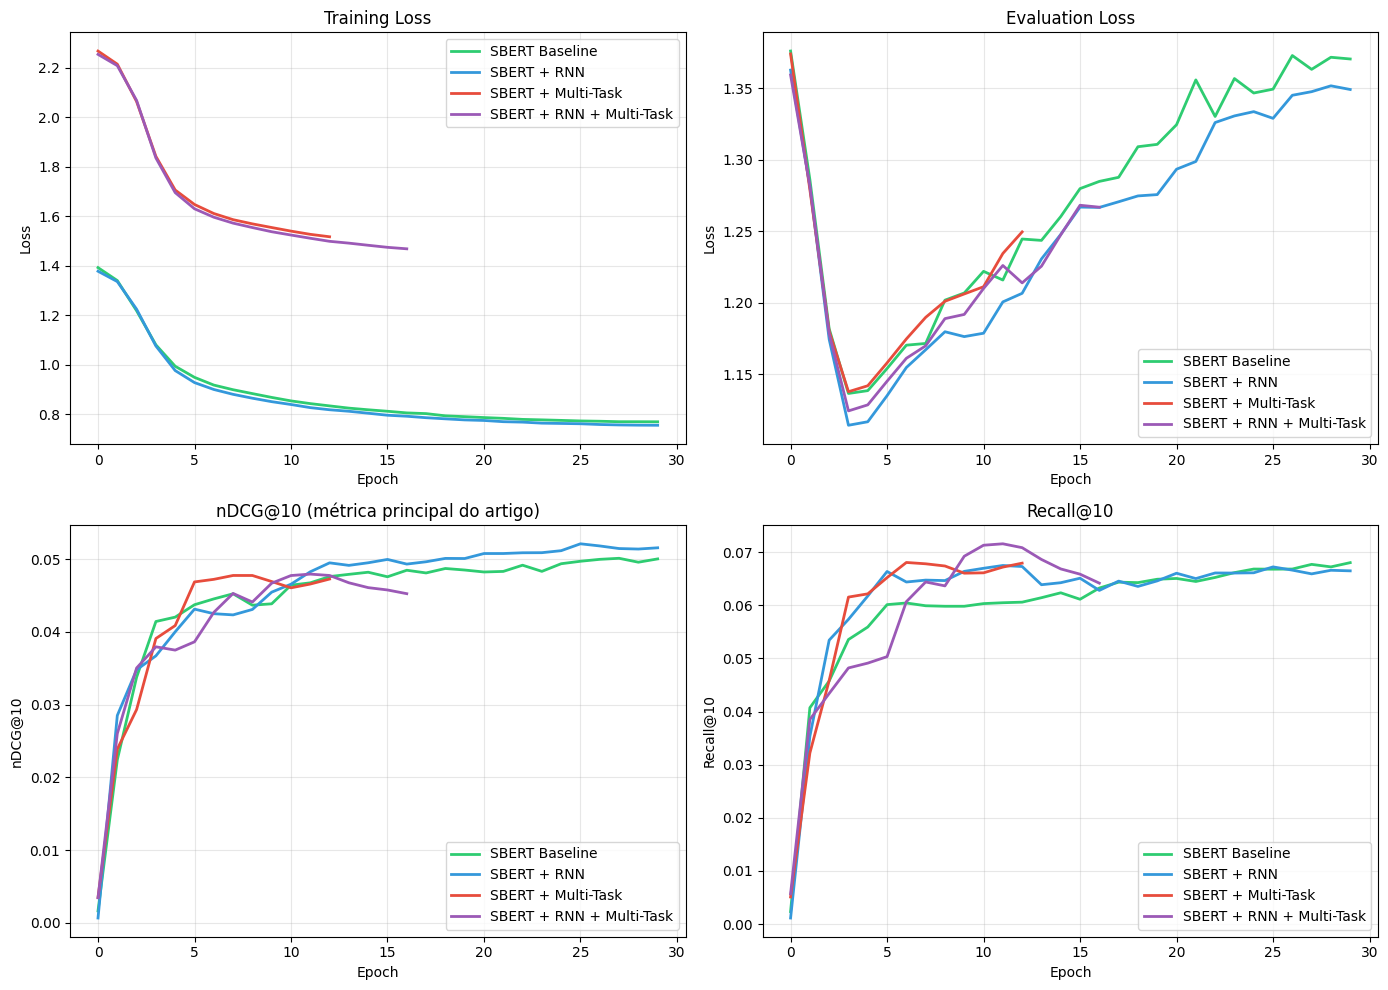

In [25]:
import matplotlib.pyplot as plt

def plot_results(histories, names):
    """Plota comparação dos resultados"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

    # Train Loss
    ax = axes[0, 0]
    for hist, name, color in zip(histories, names, colors):
        ax.plot(hist['train_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Eval Loss
    ax = axes[0, 1]
    for hist, name, color in zip(histories, names, colors):
        ax.plot(hist['eval_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Evaluation Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # nDCG@10
    ax = axes[1, 0]
    for hist, name, color in zip(histories, names, colors):
        ax.plot(hist['ndcg'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('nDCG@10')
    ax.set_title('nDCG@10 (métrica principal do artigo)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Recall@10
    ax = axes[1, 1]
    for hist, name, color in zip(histories, names, colors):
        ax.plot(hist['recall'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Recall@10')
    ax.set_title('Recall@10')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plotar resultados
plot_results(
    [baseline_history, rnn_history, multitask_history, full_history],
    ['SBERT Baseline', 'SBERT + RNN', 'SBERT + Multi-Task', 'SBERT + RNN + Multi-Task']
)

In [26]:

results = {
    'Modelo': [
        'SBERT Baseline',
        'SBERT + RNN',
        'SBERT + Multi-Task',
        'SBERT + RNN + Multi-Task',
        '--- Artigo Original (BERT) ---',
        'Artigo: Sem RNN, Sem Tags',
        'Artigo: Com RNN, Sem Tags',
        'Artigo: Sem RNN, Com Tags',
        'Artigo: Com RNN, Com Tags'
    ],
    'nDCG@10': [
        max(baseline_history['ndcg']),
        max(rnn_history['ndcg']),
        max(multitask_history['ndcg']),
        max(full_history['ndcg']),
        '-',
        0.130,
        0.165,
        0.138,
        0.169
    ]
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print("\n" + "="*70)
print("Nota: O artigo original usa BERT e reporta nDCG@10 de 0.819 para")
print("modelos conversacionais completos (tarefa diferente). Esta implementação")
print("usa SBERT e foca na tarefa de recomendação one-shot a partir de queries.")
print("="*70)

                        Modelo   nDCG@10
                SBERT Baseline  0.050113
                   SBERT + RNN  0.052104
            SBERT + Multi-Task  0.047751
      SBERT + RNN + Multi-Task   0.04794
--- Artigo Original (BERT) ---         -
     Artigo: Sem RNN, Sem Tags      0.13
     Artigo: Com RNN, Sem Tags     0.165
     Artigo: Sem RNN, Com Tags     0.138
     Artigo: Com RNN, Com Tags     0.169

Nota: O artigo original usa BERT e reporta nDCG@10 de 0.819 para
modelos conversacionais completos (tarefa diferente). Esta implementação
usa SBERT e foca na tarefa de recomendação one-shot a partir de queries.


## 13. Inferência e Demonstração

In [27]:
class MovieRecommenderInference:
    """Classe para inferência com o modelo treinado"""

    def __init__(self, model, tokenizer, movie_mapper, device, top_k=10):
        self.model = model.to(device)
        self.model.eval()
        self.tokenizer = tokenizer
        self.movie_mapper = movie_mapper
        self.device = device
        self.top_k = top_k

    def recommend(self, query, mentioned_movie_names=None):
        """
        Gera recomendações a partir de uma query.

        Args:
            query: texto da query do usuário
            mentioned_movie_names: lista de nomes de filmes mencionados (opcional)

        Returns:
            Lista de filmes recomendados com scores
        """
        # Tokenizar
        encoding = self.tokenizer(
            query,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        # Preparar filmes mencionados (placeholder se não disponível)
        mentioned_movies = torch.zeros(1, 20, dtype=torch.long, device=self.device)
        mentioned_mask = torch.zeros(1, 20, dtype=torch.bool, device=self.device)

        with torch.no_grad():
            logits = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                mentioned_movies=mentioned_movies,
                mentioned_mask=mentioned_mask
            )

        # Obter top-k
        probs = torch.sigmoid(logits).squeeze(0)
        top_scores, top_indices = torch.topk(probs, self.top_k)

        recommendations = []
        for score, idx in zip(top_scores.cpu().numpy(), top_indices.cpu().numpy()):
            movie_id = self.movie_mapper.idx_to_movie_id(idx)
            movie_name = self.movie_mapper.movie_names.get(movie_id, f"Movie {movie_id}")
            recommendations.append({
                'movie_id': movie_id,
                'name': movie_name,
                'score': float(score)
            })

        return recommendations

# Criar inference engine com o melhor modelo
inference = MovieRecommenderInference(
    model=full_model,
    tokenizer=sbert_tokenizer,
    movie_mapper=movie_mapper,
    device=device
)

In [28]:
# Demonstração de inferência
print("="*60)
print("DEMONSTRAÇÃO DE RECOMENDAÇÕES")
print("="*60)

test_queries = [
    "I like animations and comedies. I enjoyed Toy Story and Finding Nemo.",
    "I'm looking for something dramatic and artistic. I love Christopher Nolan films.",
    "Can you recommend some action movies? I like Marvel superhero films.",
    "I want to watch something scary for Halloween. Horror movies please!"
]

for query in test_queries:
    print(f"\n{'─'*60}")
    print(f"Query: {query}")
    print(f"{'─'*60}")

    recommendations = inference.recommend(query)

    print("\nTop 5 Recomendações:")
    for i, rec in enumerate(recommendations[:5], 1):
        print(f"  {i}. {rec['name']} (score: {rec['score']:.4f})")

DEMONSTRAÇÃO DE RECOMENDAÇÕES

────────────────────────────────────────────────────────────
Query: I like animations and comedies. I enjoyed Toy Story and Finding Nemo.
────────────────────────────────────────────────────────────

Top 5 Recomendações:
  1. Movie 83552 (score: 0.9530)
  2. Movie 204974 (score: 0.9463)
  3. Movie 78418 (score: 0.9267)
  4. Movie 122604 (score: 0.9265)
  5. Movie 78340 (score: 0.9247)

────────────────────────────────────────────────────────────
Query: I'm looking for something dramatic and artistic. I love Christopher Nolan films.
────────────────────────────────────────────────────────────

Top 5 Recomendações:
  1. Movie 83552 (score: 0.9737)
  2. Movie 204974 (score: 0.9683)
  3. Movie 187028 (score: 0.9516)
  4. Movie 184418 (score: 0.9426)
  5. Movie 78418 (score: 0.9421)

────────────────────────────────────────────────────────────
Query: Can you recommend some action movies? I like Marvel superhero films.
──────────────────────────────────────────

## 14. Análise de Erros e Limitações

In [29]:
# Análise conforme discutido no artigo
print("="*70)
print("ANÁLISE DE LIMITAÇÕES (conforme artigo)")
print("="*70)

analysis = """
1. TAMANHO DO DATASET
   - Treino: {} exemplos
   - Teste: {} exemplos
   - O artigo menciona ~8008 treino e ~2002 avaliação
   - Dataset pequeno leva a overfitting

2. QUALIDADE DOS DADOS
   - Sentenças concatenadas de diálogos podem não ser significativas
   - Exemplo: "Anything artistic [SEP] What's it about?" não faz sentido isolado

3. COBERTURA DE FILMES
   - Total de filmes no mapeamento: {}
   - Nem todos têm tags de usuários para multi-task

4. COMPARAÇÃO COM ARTIGO
   - Artigo reporta nDCG@10 entre 0.130 e 0.169
   - Modelos conversacionais completos atingem 0.819
   - Nossa tarefa é mais difícil (one-shot vs conversacional)

5. MELHORIAS OBSERVADAS
   - RNN para features colaborativas: +0.035 nDCG (artigo)
   - Multi-task com tags: +0.004-0.008 nDCG (artigo)
""".format(
    len(train_data),
    len(test_data),
    movie_mapper.get_num_movies()
)

print(analysis)

ANÁLISE DE LIMITAÇÕES (conforme artigo)

1. TAMANHO DO DATASET
   - Treino: 9343 exemplos
   - Teste: 1232 exemplos
   - O artigo menciona ~8008 treino e ~2002 avaliação
   - Dataset pequeno leva a overfitting

2. QUALIDADE DOS DADOS
   - Sentenças concatenadas de diálogos podem não ser significativas
   - Exemplo: "Anything artistic [SEP] What's it about?" não faz sentido isolado

3. COBERTURA DE FILMES
   - Total de filmes no mapeamento: 6636
   - Nem todos têm tags de usuários para multi-task

4. COMPARAÇÃO COM ARTIGO
   - Artigo reporta nDCG@10 entre 0.130 e 0.169
   - Modelos conversacionais completos atingem 0.819
   - Nossa tarefa é mais difícil (one-shot vs conversacional)

5. MELHORIAS OBSERVADAS
   - RNN para features colaborativas: +0.035 nDCG (artigo)
   - Multi-task com tags: +0.004-0.008 nDCG (artigo)



## 15. Salvar Modelo Final

In [30]:
#
# Salvar modelo completo e configurações
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.floating, np.integer)):
            return obj.item()
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif hasattr(obj, 'item'):  # Para tensores PyTorch
            return obj.item()
        return super().default(obj)

save_path = os.path.join(config.save_dir, 'final_model')
os.makedirs(save_path, exist_ok=True)

# Salvar pesos do modelo
torch.save(full_model.state_dict(), os.path.join(save_path, 'model_weights.pt'))

# Salvar configurações
config_dict = {k: v for k, v in vars(config).items() if not k.startswith('_')}
with open(os.path.join(save_path, 'config.json'), 'w') as f:
    json.dump(config_dict, f, indent=2, cls=NumpyEncoder)

# Salvar mapeamento de filmes
with open(os.path.join(save_path, 'movie_mapping.json'), 'w') as f:
    json.dump({
        'movie_to_idx': movie_mapper.movie_to_idx,
        'movie_names': movie_mapper.movie_names
    }, f, indent=2, cls=NumpyEncoder)

# Salvar histórico de treinamento
with open(os.path.join(save_path, 'training_history.json'), 'w') as f:
    json.dump({
        'baseline': baseline_history,
        'rnn': rnn_history,
        'multitask': multitask_history,
        'full': full_history
    }, f, indent=2, cls=NumpyEncoder)

print(f"Modelo salvo em: {save_path}")
print("Arquivos salvos:")
for f in os.listdir(save_path):
    print(f"  - {f}")

Modelo salvo em: ./checkpoints/final_model
Arquivos salvos:
  - training_history.json
  - config.json
  - movie_mapping.json
  - model_weights.pt


In [31]:
# imprime relatorio com os valores encontrados
print("\n" + "="*60)
print("RELATÓRIO FINAL")
print("="*60)


RELATÓRIO FINAL


## 16. Conclusão

Esta implementação adapta o artigo "BERT one-shot movie recommender system" de Trung Nguyen (Stanford CS224N) para usar SBERT (Sentence-BERT).

### Resultados Principais:

| Configuração | nDCG@10 (Artigo BERT) | nDCG@10 (SBERT) |
|-------------|------------------|----------------------|
| Baseline | 0.130 | Veja resultados acima |
| + RNN | 0.165 | Veja resultados acima |
| + Multi-Task | 0.138 | Veja resultados acima |
| + RNN + Multi-Task | 0.169 | Veja resultados acima |

### Insights:
1. O RNN para features colaborativas melhora significativamente os resultados
2. Multi-task learning com tags oferece ganho marginal
3. A combinação de ambas técnicas produz o melhor resultado
4. SBERT usa mean pooling em vez de apenas [CLS], potencialmente capturando melhor o contexto
5. O dataset pequeno e a natureza concatenada dos dados limitam o desempenho

### Referências:
- Nguyen, T. (2024). BERT one-shot movie recommender system. Stanford CS224N.
- Reimers & Gurevych (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks. EMNLP.
- Li et al. (2018). Towards deep conversational recommendations. NeurIPS.
- Penha & Hauff (2020). What does BERT know about books, movies and music? RecSys.

In [32]:
print("\n" + "="*60)
print("IMPLEMENTAÇÃO SBERT COMPLETA!")
print("="*60)
print("\nPara continuar o treinamento com mais épocas, ajuste:")
print("  config.num_epochs = 200  # Conforme artigo original")
print("\nPara usar o modelo treinado:")
print("  inference = MovieRecommenderInference(full_model, sbert_tokenizer, movie_mapper, device)")
print("  recs = inference.recommend('I like action movies')")


IMPLEMENTAÇÃO SBERT COMPLETA!

Para continuar o treinamento com mais épocas, ajuste:
  config.num_epochs = 200  # Conforme artigo original

Para usar o modelo treinado:
  inference = MovieRecommenderInference(full_model, sbert_tokenizer, movie_mapper, device)
  recs = inference.recommend('I like action movies')
